# IAEA Data Analysis
The goal of this analysis is to extract useful information from the IAEA Power Reactor Information System (PRIS) database from the perspective of a country that is evaluating the best option for nuclear buildout.

-->Insert description of the database<--

The database can be accessed at the following link: https://pris.iaea.org/pris/home.aspx

## Step 1: Data Cleaning
The dataset used in this analysis was webscraped from the PRIS website where not every field is populated for every reactor. The following codeblock shows several sample rows from the dataset where it can be seen that the data contain a mix of shutdown reactors, operating reactors, and reactors under construction. The fields that have missing data (containing either "None", "NaN", or "Missing ID") are primarily determined by the operational status of the reactor.

One other field that needs to be cleaned is the "energy_supplied" field which was encoded as a pandas dataframe object showing the energy supplied by the reactor and the capacity factor for each year where data was available. 

Finally, dates need to be converted to a format that will allow for easy timespan calculations and units such as "TW.h" will need to be extracted from cells and standardized in column names.

In [43]:
import pandas as pd

df = pd.read_excel('iaea_dataset.xlsx')

df

,Unnamed: 0,country,energy_supplied,name,reactor_type,model,status,design_net_capacity,electricity_supplied,owner,...,first_criticality_date,first_grid_connection,longterm_shutdown_date,restart_date,permanent_shutdown_date,commercial_operation_date,load_factor,operation_factor,energy_availability_factor,id
0,0,ARMENIA,Year Electricity Supplied [G...,ARMENIAN-1,PWR,VVER V-270,Permanent Shutdown,376.0,25.27 TW.h,Ministry of Territorial Administration and Inf...,...,"15 Dec, 1976","22 Dec, 1976",NaN,NaN,"25 Feb, 1989","06 Oct, 1977",NC,NC,NC,1
1,1,ARMENIA,Year Electricity Supplied [GW...,ARMENIAN-2,PWR,VVER V-270,Operational,375.0,77.81 TW.h,Ministry of Territorial Administration and Inf...,...,"01 Jan, 1980","05 Jan, 1980","18 Mar, 1989","05 Nov, 1995",NaN,"03 May, 1980",64.7 %,78.7 %,65.1 %,2
2,2,ARGENTINA,Year Electricity Supplied [GW.h] Referenc...,ATUCHA-1,PHWR,PHWR KWU,Operational,319.0,101.49 TW.h,NUCLEOELECTRICA ARGENTINA S.A.,...,"13 Jan, 1974","19 Mar, 1974",NaN,NaN,NaN,"24 Jun, 1974",72.6 %,77.9 %,74.6 %,3
3,3,ARGENTINA,Year Electricity Supplied [GW.h] Referenc...,EMBALSE,PHWR,CANDU 6,Operational,608.0,146.66 TW.h,NUCLEOELECTRICA ARGENTINA S.A.,...,"13 Mar, 1983","25 Apr, 1983",NaN,NaN,NaN,"20 Jan, 1984",72.7 %,77.0 %,78.7 %,4
4,4,ARGENTINA,Year Electricity Supplied [GW.h] Reference...,ATUCHA-2,PHWR,PHWR KWU,Operational,692.0,25.44 TW.h,NUCLEOELECTRICA ARGENTINA S.A.,...,"03 Jun, 2014","25 Jun, 2014",NaN,NaN,NaN,"26 May, 2016",53.6 %,74.6 %,53.9 %,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1078,1078,BANGLADESH,None,ROOPPUR-2,PWR,VVER V-523,Under Construction,1080.0,Missing ID,Bangladesh Atomic Energy Commission,...,NaN,NaN,NaN,NaN,NaN,NaN,Missing ID,Missing ID,Missing ID,1079
1079,1079,TÜRKIYE,None,AKKUYU-2,PWR,VVER V-509,Under Construction,1114.0,Missing ID,Akkuyu Nuclear Joint Stock Company (JSC),...,NaN,NaN,NaN,NaN,NaN,NaN,Missing ID,Missing ID,Missing ID,1080
1080,1080,TÜRKIYE,None,AKKUYU-3,PWR,VVER V-509,Under Construction,1114.0,Missing ID,Akkuyu Nuclear Joint Stock Company (JSC),...,NaN,NaN,NaN,NaN,NaN,NaN,Missing ID,Missing ID,Missing ID,1081
1081,1081,TÜRKIYE,None,AKKUYU-4,PWR,VVER V-509,Under Construction,1114.0,Missing ID,Akkuyu Nuclear Joint Stock Company (JSC),...,NaN,NaN,NaN,NaN,NaN,NaN,Missing ID,Missing ID,Missing ID,1082


In [44]:
def process_col(name):
    return " ".join([word.capitalize() for word in name.split("_")]) 

df = (
    df.drop(['Unnamed: 0'], axis=1)
    .rename(process_col, axis="columns")
    .rename(columns={
        "Design Net Capacity": "Design Net Capacity (MWe)",
        "Electricity Supplied": "Electricity Supplied (TWh)"
    })
    .applymap(lambda x: "None" if x == "Missing ID" or pd.isna(x) else x)
)

id_col = df.pop("Id")
df.insert(0, id_col.name, id_col)

df.tail(2)

,Id,Country,Energy Supplied,Name,Reactor Type,Model,Status,Design Net Capacity (MWe),Electricity Supplied (TWh),Owner,...,Construction Start Date,First Criticality Date,First Grid Connection,Longterm Shutdown Date,Restart Date,Permanent Shutdown Date,Commercial Operation Date,Load Factor,Operation Factor,Energy Availability Factor
1081,1082,TÜRKIYE,None,AKKUYU-4,PWR,VVER V-509,Under Construction,1114.0,None,Akkuyu Nuclear Joint Stock Company (JSC),...,"21 Jul, 2022",None,None,None,None,None,None,None,None,None
1082,1083,CHINA,None,ZHANGZHOU-1,PWR,HPR1000,Under Construction,1126.0,None,None,...,"16 Oct, 2019",None,None,None,None,None,None,None,None,None


In [45]:
def process_date(date):
    return date if date == "None" else datetime.strptime(date, "%d %b, %Y")

from datetime import datetime 

df["Construction Start Date"] = df["Construction Start Date"].map(process_date)
df["First Criticality Date"] = df["First Criticality Date"].map(process_date)
df["First Grid Connection"] = df["First Grid Connection"].map(process_date)
df["Longterm Shutdown Date"] = df["Longterm Shutdown Date"].map(process_date)
df["Restart Date"] = df["Restart Date"].map(process_date)
df["Permanent Shutdown Date"] = df["Permanent Shutdown Date"].map(process_date)
df["Commercial Operation Date"] = df["Commercial Operation Date"].map(process_date)

In [46]:
def calc_duration(row, col_start, col_end):
    if row[col_start] == "None" or row[col_end] == "None":
        return "None"
    return row[col_end] - row[col_start]
    
df["Construction Duration"] = df.apply(lambda row: calc_duration(row, "Construction Start Date", "First Grid Connection"), axis=1)
df["Commissioning Duration"] = df.apply(lambda row: calc_duration(row, "First Grid Connection", "Commercial Operation Date"), axis=1)
df["Operation Duration"] = df.apply(lambda row: calc_duration(row, "Commercial Operation Date", "Permanent Shutdown Date"), axis=1)

<AxesSubplot: xlabel='Reactor Type'>

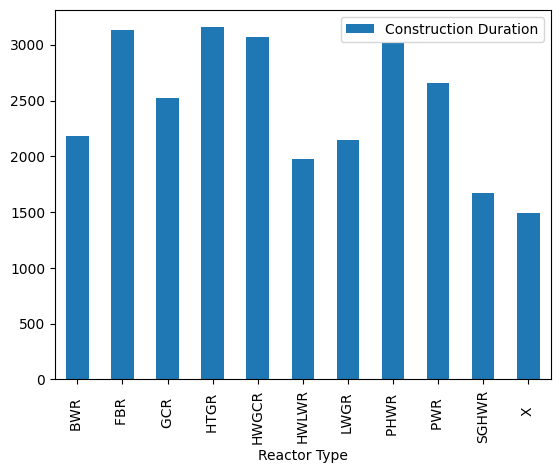

In [81]:
import matplotlib.pyplot as plt

from datetime import timedelta



plot_data = df.query('`Reactor Type` != "None" & `Construction Duration` != "None"').groupby("Reactor Type")["Construction Duration"].mean().reset_index()

plot_data["Construction Duration"] = plot_data["Construction Duration"].map(lambda x: x.days)

plot_data.plot.bar(x="Reactor Type",y="Construction Duration")

# need to account for reactor capacity when plotting these

In [33]:
datetime.timedelta

AttributeError: type object 'datetime.datetime' has no attribute 'timedelta'